Main idea: Fetch multiple datasets of indexes and stocks correlated news to that index. (News only go back one year)
Then we train the model on the multiple datasets and test it on the last dataset.

1. Fetch the stock data from Yahoo Finance
2. Fetch the news data from NewsAPI
3. Preprocess stock data. We will give the model open, close, high, low
4. Preprocess news data to sentiment labels. then backfill the sentiment labels so that there are no missing values
5. Merge the stock data and news data
6. Train the model on the multiple datasets
7. Test the model on the last dataset
8. Evaluate the model
9. Save the model
10. Make predictions

In [179]:
#Data fetching 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from pygooglenews import GoogleNews

In [180]:
List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX']
#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', 'XLE', 'AAPL','MSFT','AMZN','GOOGL','FB','TSLA','BRK-A','JPM','JNJ','V','WMT','PG','UNH','MA','INTC','VZ','HD','DIS','MRK','KO','PFE','BAC','PEP','CSCO','CMCSA','NFLX','T','NVDA','ADBE','ABT','XOM','CRM','TMO','ACN','CVX','NKE','LLY','COST','ABBV','DHR','NEE','AVGO','MDT','QCOM','TXN','UNP','LIN','UPS','HON','SBUX','AMT','ORCL','LOW','IBM','MO','AMD','AMGN','C','CAT','BA','MMM','GE','GS','MS','FDX','PYPL','CHTR','AMAT','LMT']

time_period = '365d'

In [181]:
#Fetch stock data
stock_data = {}
for index in List_of_indexes:
    #Manually create the dataframe
    collected_data = yf.download(index, period ="1y")
    df = pd.DataFrame()
    df['Open'] = collected_data['Open']
    df['Close'] = collected_data['Close']
    df['High'] = collected_data['High']
    df['Low'] = collected_data['Low']
    stock_data[index] = df
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [182]:
#Fetch news data
news_data = {}
gn = GoogleNews()
for index in List_of_indexes:
    news_data[index] = gn.search(index, when='1y')
    print("Fetched news data for: ", index)
    print("Number of articles: ", len(news_data[index]['entries']))
    #Convert to dataframe
    news_data[index] = pd.DataFrame(news_data[index]['entries'])




Fetched news data for:  ^GSPC
Number of articles:  68
Fetched news data for:  ^DJI
Number of articles:  99
Fetched news data for:  ^IXIC
Number of articles:  100
Fetched news data for:  ^RUT
Number of articles:  96
Fetched news data for:  ^FTSE
Number of articles:  100
Fetched news data for:  ^N225
Number of articles:  93
Fetched news data for:  ^HSI
Number of articles:  100
Fetched news data for:  ^GDAXI
Number of articles:  25
Fetched news data for:  ^OMX
Number of articles:  100


In [183]:
#Clean up the news data wich contains: title,title_detail,links,link,id,guidislink,published,published_parsed,summary,summary_detail,source,sub_articles
#We will put the title through a sentiment analysis model and then put all none existing values as 0
#Finbert model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#Test the model
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


news_sentiments = {}

#Add date and sentiment to the dataframe
for index in List_of_indexes:
    news_sentiments[index] = []
    print("Processing news data for: ", index)
    for i in range(len(news_data[index])):
        #print(news_data[index].iloc[i]['title'])
        sentiment = classifier(news_data[index].iloc[i]['title'], top_k=None)
        postive_score = sentiment[0]['score']
        negative_score = sentiment[1]['score']
        neutral_score = sentiment[2]['score']
        #Convert date to dtype='datetime64[ns] so that we can later can merge the dataframes
        reformmated_time_stamp = pd.to_datetime(news_data[index].iloc[i]['published']).date()
        news_sentiments[index] = news_sentiments[index] + [{'Date': reformmated_time_stamp, 'positive_score': postive_score, 'negative_score': negative_score, 'neutral_score': neutral_score}]
    news_sentiments[index] = pd.DataFrame(news_sentiments[index])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


Processing news data for:  ^GSPC
Processing news data for:  ^DJI
Processing news data for:  ^IXIC
Processing news data for:  ^RUT
Processing news data for:  ^FTSE
Processing news data for:  ^N225
Processing news data for:  ^HSI
Processing news data for:  ^GDAXI
Processing news data for:  ^OMX


In [184]:
# Average sentiment for days with multiple articles

for index in List_of_indexes:
    # Group by date and calculate mean sentiment scores
    news_sentiments[index] = (
        news_sentiments[index]
        .groupby('Date')
        .mean()
        .fillna(0)  # Handle NaN values
        .reset_index()  # Ensure 'date' becomes a column
        .set_index('Date')  # Set 'date' as the index
        .sort_index()  # Ensure the index is sorted
    )
    
    
# Define a common date range
common_index = pd.date_range(
    start=pd.Timestamp(min(pd.Timestamp(stock_data[index].index.min()), pd.Timestamp(news_sentiments[index].index.min()))),
    end=pd.Timestamp(max(pd.Timestamp(stock_data[index].index.max()), pd.Timestamp(news_sentiments[index].index.max()))),
    freq='D'  # Daily frequency
)

# Reindex both dataframes so they have the same index
stock_data[index] = stock_data[index].reindex(common_index).fillna(-1)  # Fill missing stock data with 0
news_sentiments[index] = news_sentiments[index].reindex(common_index).fillna(0)  # Fill missing sentiment data with 0

# Combine stock data and news sentiment into one DataFrame
combined_data = {}


# Reindex both dataframes

for index in List_of_indexes:
    # Ensure stock_data and news_sentiments have compatible indices
    stock_data[index].index = pd.to_datetime(stock_data[index].index).normalize()  # Normalize index to date only
    news_sentiments[index].index = pd.to_datetime(news_sentiments[index].index).normalize()  # Normalize index to date only
    
    # Merge stock data and news data
    combined_data[index] = pd.merge(
        stock_data[index], 
        news_sentiments[index], 
        how='left', 
        left_index=True, 
        right_index=True
    )
    
    #Drop all close values that are -1
    combined_data[index] = combined_data[index][combined_data[index].Close != -1]
    
    #Fill all missing values with 0
    combined_data[index] = combined_data[index].fillna(0)
    


In [185]:
#Check size of the dataframes
for index in List_of_indexes:
    print("Size of dataframe for ", index, " is: ", combined_data[index].shape)

Size of dataframe for  ^GSPC  is:  (253, 7)
Size of dataframe for  ^DJI  is:  (253, 7)
Size of dataframe for  ^IXIC  is:  (253, 7)
Size of dataframe for  ^RUT  is:  (253, 7)
Size of dataframe for  ^FTSE  is:  (255, 7)
Size of dataframe for  ^N225  is:  (247, 7)
Size of dataframe for  ^HSI  is:  (247, 7)
Size of dataframe for  ^GDAXI  is:  (257, 7)
Size of dataframe for  ^OMX  is:  (254, 7)


In [186]:
#Reformat the dataframes to be able to train the model
#We will use the last 30 days as testa data and the rest as training data as the data comes from diffrent indexes
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def create_sequences(input_data, output_data, timesteps):
    xs, ys = [], []
    for i in range(len(input_data) - timesteps):
        x = input_data[i:(i + timesteps)]
        y = output_data[i + timesteps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

timesteps = 30
input_dim = 7
output_dim = 2


xs = []
ys = []
for index in List_of_indexes: 
    data = combined_data[index]
    # Normalize data
    input_features = data[['Open', 'Close', 'High', 'Low', 'positive_score', 'negative_score', 'neutral_score']].values
    output_feature = data[['High','Low']].values
    scaler = MinMaxScaler()
    input_features_scaled = scaler.fit_transform(input_features)
    output_feature_scaled = scaler.fit_transform(output_feature)
    
    # Create sequences
    x, y = create_sequences(input_features_scaled, output_feature_scaled, timesteps)
    xs.append(x)
    ys.append(y)
    
# Concatenate all sequences
xs = np.concatenate(xs)
ys = np.concatenate(ys)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, shuffle=False)


In [188]:
model = Sequential() 
model.add(LSTM(128, input_shape=(timesteps, input_dim)))
model.add(Dense(output_dim))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=32)


Epoch 1/100


/Users/palhagen/.virtualenvs/Scalable_Machine_learning_Project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0691
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0060
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0042
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031
Epoch 14/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 15/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
E

In [216]:
#Evaluate the model
test_results = model.evaluate(x_test, y_test)
test_loss = test_results
print(f'Test Loss: {test_loss}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012    
Test Loss: 0.0017566531896591187


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


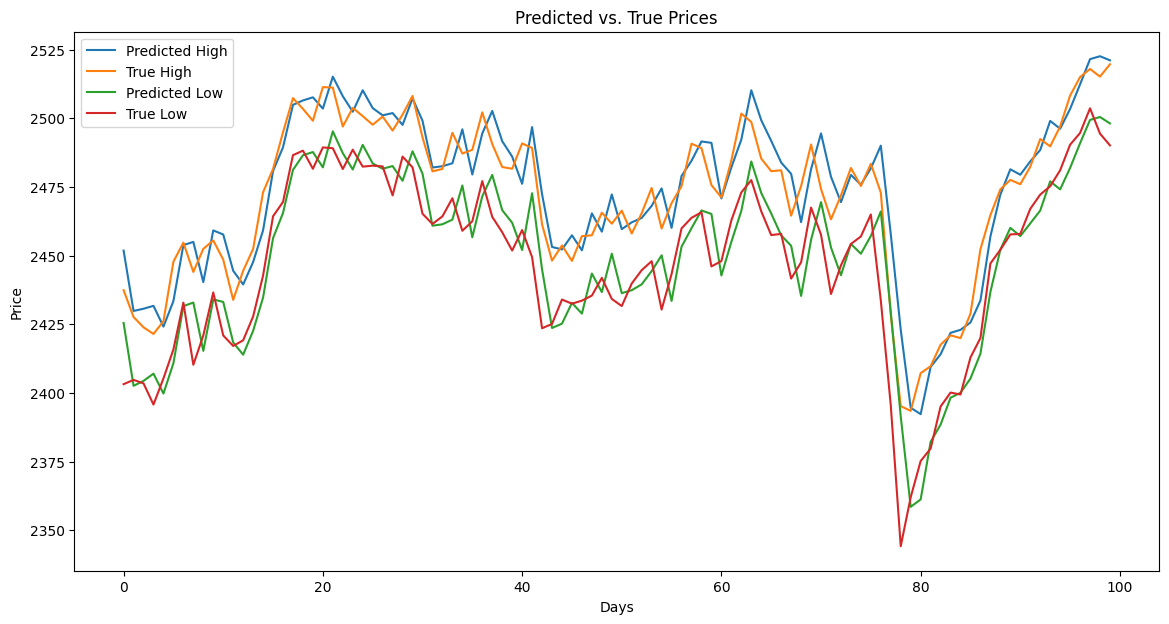

In [194]:
#Print the predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test)

start = 0
end = 100
#Plot the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions[start:end, 0], label='Predicted High')
plt.plot(y_test_unscaled[start:end, 0], label='True High')
plt.plot(predictions[start:end, 1], label='Predicted Low')
plt.plot(y_test_unscaled[start:end, 1], label='True Low')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted vs. True Prices')

plt.legend()
plt.show()

In [197]:
#Save the model to hopsworks
import hopsworks
import os
import warnings
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


In [198]:
with open('./project_api_key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    print("API Key is set")
    print("First 5 characters of API Key: ", os.environ["HOPSWORKS_API_KEY"][:5])

API Key is set
First 5 characters of API Key:  pwWjy


In [202]:
model_dir = "FinanceModel"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [213]:
#Get loss of model 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,672 (819.04 KB)

 Trainable params: 69,890 (273.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,782 (546.03 KB)

In [218]:
project = hopsworks.login() 

model_dir = "Resources/Models"

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(x_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()
model.save(model_dir + "/model.keras") 

mr = project.get_model_registry()

#Get model metrics

res_dict = {
    "MSE" : test_loss
}

aq_model = mr.python.create_model(
    name="FinanceModel", 
    metrics= res_dict,
    model_schema=model_schema,
    description="Predicting stock prices using LSTM model trained on multiple indexes.",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)


2024-12-19 21:10:59,013 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-19 21:10:59,016 INFO: Initializing external client
2024-12-19 21:10:59,016 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-19 21:11:00,281 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1168540


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/862388 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/863608 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/219 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1168540/models/FinanceModel/1


Model(name: 'FinanceModel', version: 1)